#**Ember-gép interakciók - nagy házi**
2023. 1. félév

Heizner Levente,

Tugyi Beatrix



---



---



#**Imports**

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import pandas as pd

cudnn.benchmark = True
plt.ion()   # interactive mode

# **Data collection and augmentations**

In [2]:
root = './data'

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomCrop(200, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=40),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


val_test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.Flowers102(root=root, split='train', download=True, transform=train_transform) + torchvision.datasets.Flowers102(root=root, split='train', download=True, transform=train_transform)
val_dataset = torchvision.datasets.Flowers102(root=root, split='val', download=True, transform=val_test_transform)
test_dataset = torchvision.datasets.Flowers102(root=root, split='test', download=True, transform=val_test_transform)

100%|██████████| 344862509/344862509 [00:01<00:00, 246206196.02it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 1776827.52it/s]


100%|██████████| 14989/14989 [00:00<00:00, 8947967.93it/s]


###Look at the data and the labels

In [ ]:
labels =  np.unique([label for _, label in train_dataset])
print('num classes', labels.size)

num classes 102


In [ ]:
import pandas as pd

In [ ]:
labels =  [label for _, label in train_dataset]

In [ ]:
l = pd.DataFrame(labels)

In [ ]:
len(l)

2040

In [ ]:
l.value_counts()

0      20
64     20
74     20
73     20
72     20
       ..
31     20
30     20
29     20
28     20
101    20
Length: 102, dtype: int64

In [ ]:
root = './data'
full_dataset = torchvision.datasets.Flowers102(root=root + '/full', download=True)

100%|██████████| 344862509/344862509 [00:12<00:00, 28095980.53it/s]


Extracting data/full/flowers-102/102flowers.tgz to data/full/flowers-102


100%|██████████| 502/502 [00:00<00:00, 435208.89it/s]


100%|██████████| 14989/14989 [00:00<00:00, 13850721.01it/s]


###Collecting the name of the labels from Tensorflow, because the pytorch dataset does not include them

In [3]:
! pip -q install tensorflow-datasets
import tensorflow_datasets as tfds

In [4]:
ds, ds_info = tfds.load('oxford_flowers102', split='train', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete8DXL35/oxford_flowers102-train.tfrecord*…

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete8DXL35/oxford_flowers102-test.tfrecord*.…

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete8DXL35/oxford_flowers102-validation.tfre…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [5]:
label_names = ds_info.features['label'].names

In [6]:
print(label_names)

['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia?', 'ca

In [7]:
xml_content = '<string-array name="flower_names">\n'
xml_content += '\n'.join([f'    <item>{name.capitalize()}</item>' for name in label_names])
xml_content += '\n</string-array>'

file_name = '/content/flower_labels.txt'
with open(file_name, 'w') as file:
    file.write(xml_content)

## Create Dataloaders and visualize some images

In [8]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

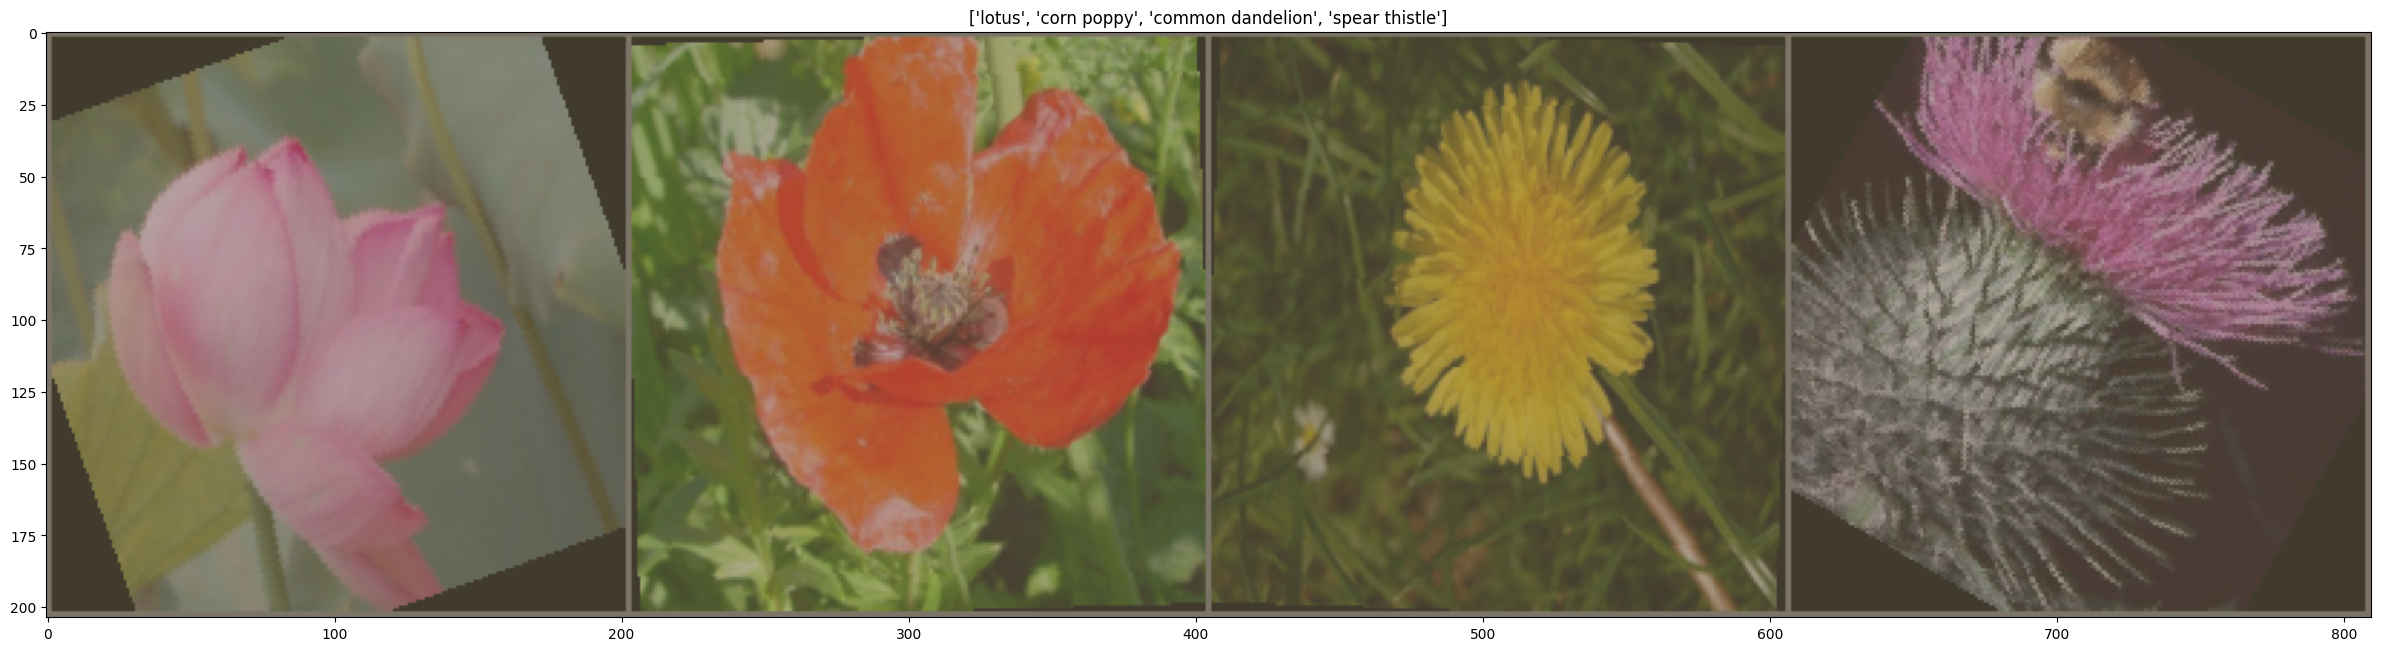

In [9]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

inputs, classes = inputs[1:5], classes[1:5]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

plt.figure(figsize = (30,30))
imshow(out, title=[label_names[x] for x in classes])

## Define if we want to train on GPU or CPU

In [10]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Moving to", device)
else:
    device = torch.device("cpu")
    print("Moving to", device)

Moving to cuda


#Train and test functions

In [11]:
def test_model(model):
  model.eval()   # Set model to evaluate mode
  dataloader = test_loader
  dataset_size = len(test_dataset)
  running_corrects = 0
  for inputs, labels in dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      running_corrects += torch.sum(preds == labels.data)
  acc = running_corrects / dataset_size
  return acc


def train_model(model, criterion, optimizer, scheduler, num_epochs=10, quiet = False):
    since = time.time()
    history =  pd.DataFrame(columns=["train_loss", "train_acc", "val_loss", "val_acc" ])
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            if not quiet:
              print(f'Epoch {epoch}/{num_epochs - 1}')
              print('-' * 10)

            # Each epoch has a training and validation phase
            epoch_history = {}
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                    dataloader = train_loader
                    dataset_size = len(train_dataset)
                else:
                    model.eval()   # Set model to evaluate mode
                    dataloader = val_loader
                    dataset_size = len(val_dataset)

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_size
                epoch_acc = running_corrects.double() / dataset_size

                if phase == 'train':
                  epoch_history["train_loss"] = epoch_loss.clone().cpu().item() if torch.is_tensor(epoch_loss) else epoch_loss
                  epoch_history["train_acc"] = epoch_acc.clone().cpu().item() if torch.is_tensor(epoch_acc) else epoch_acc
                if phase == 'val':
                  epoch_history["val_loss"] = epoch_loss.clone().cpu().item() if torch.is_tensor(epoch_loss) else epoch_loss
                  epoch_history["val_acc"] = epoch_acc.clone().cpu().item() if torch.is_tensor(epoch_acc) else epoch_acc

                if not quiet:
                   print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
            if  not quiet:
              print()
            epoch_df = pd.DataFrame([epoch_history])
            history = pd.concat([history, epoch_df], ignore_index=True)

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, history

In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//4, 4, images_so_far)
                ax.axis('off')
                #if label_names[preds[j]] != label_names[labels.cpu()[j]]:
                ax.set_title(f'predicted: {label_names[preds[j]]}\n actual: {label_names[labels.cpu()[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Hiperparams optimalization

In [ ]:
opt = ['sgd'] #adam
lr = [0.05, 0.01, 0.005 ]
weight_decay = [1e-5, 1e-4, 1e-3]
criterion = nn.CrossEntropyLoss()

In [ ]:
for o in opt:
  for w in weight_decay:
     for l in lr:
      model = models.mobilenet_v3_large(weights = 'IMAGENET1K_V2', pretrained=True)
      num_classes = len(labels)
      model.classifier[3] = nn.Linear(model.classifier[3].in_features,num_classes)
      model = model.to(device)
      if (o == "sgd"):
        optimizer = optim.SGD(model.parameters(), lr = l, momentum = 0.9, weight_decay =w)
      if (o== "adam"):
        optimizer = optim.Adam(model.parameters(), lr=l, weight_decay=w)
      if (o == "wadam"):
        optimizer = optim.AdamW(model.parameters(), lr=l, weight_decay=w)
      exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
      model, history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=6, quiet = True)
      acc = test_model(model)
      print("params: opt: ", o, "lr: ", l, "weight decay: ", w)
      print("Az elkészült modell pontossága:")
      print(acc.cpu().item())
      print('___________________________________')

In [ ]:
opt = ['adam', 'wadam']
lr = [0.01, 0.005, 0.001, 0.0005 ]
weight_decay = [1e-5, 1e-4, 1e-3]

In [ ]:
for o in opt:
  for w in weight_decay:
     for l in lr:
      model = models.mobilenet_v3_large(weights = 'IMAGENET1K_V2', pretrained=True)
      num_classes = len(labels)
      model.classifier[3] = nn.Linear(model.classifier[3].in_features,num_classes)
      model = model.to(device)
      if (o == "sgd"):
        optimizer = optim.SGD(model.parameters(), lr = l, momentum = 0.9, weight_decay =w)
      if (o== "adam"):
        optimizer = optim.Adam(model.parameters(), lr=l, weight_decay=w)
      if (o == "wadam"):
        optimizer = optim.AdamW(model.parameters(), lr=l, weight_decay=w)
      exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
      model, history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=6, quiet = True)
      acc = test_model(model)
      print("params: opt: ", o, "lr: ", l, "weight decay: ", w)
      print("Az elkészült modell pontossága:")
      print(acc.cpu().item())
      print('___________________________________')


## Legjobb tanítás

Training complete in 2m 44s

Best val Acc: 0.904902

params: opt:  sgd lr:  0.005 weight decay:  0.001

Az elkészült modell pontossága:
0.8659944534301758
____________________

#Train

In [13]:
model = models.quantization.mobilenet_v3_large(weights = 'IMAGENET1K_V2', pretrained=True,quentize=True)
num_classes = 102
model.classifier[3] = nn.Linear(model.classifier[3].in_features,num_classes)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3)
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
optimizer = optim.SGD(model.parameters(), lr = 0.005, momentum = 0.9, weight_decay =1e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 121MB/s] 


In [14]:
num_classes

102

In [15]:
model, history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------
train Loss: 3.3272 Acc: 0.3294
val Loss: 1.9805 Acc: 0.6255

Epoch 1/14
----------
train Loss: 0.5838 Acc: 0.8500
val Loss: 0.6656 Acc: 0.8353

Epoch 2/14
----------
train Loss: 0.1541 Acc: 0.9667
val Loss: 0.6312 Acc: 0.8353

Epoch 3/14
----------
train Loss: 0.0650 Acc: 0.9858
val Loss: 0.5199 Acc: 0.8667

Epoch 4/14
----------
train Loss: 0.0423 Acc: 0.9931
val Loss: 0.4682 Acc: 0.8725

Epoch 5/14
----------
train Loss: 0.0215 Acc: 0.9985
val Loss: 0.4325 Acc: 0.8882

Epoch 6/14
----------
train Loss: 0.0168 Acc: 0.9990
val Loss: 0.4138 Acc: 0.9010

Epoch 7/14
----------
train Loss: 0.0120 Acc: 0.9985
val Loss: 0.3802 Acc: 0.9010

Epoch 8/14
----------
train Loss: 0.0108 Acc: 0.9990
val Loss: 0.3699 Acc: 0.9078

Epoch 9/14
----------
train Loss: 0.0095 Acc: 0.9995
val Loss: 0.3715 Acc: 0.9059

Epoch 10/14
----------
train Loss: 0.0101 Acc: 0.9990
val Loss: 0.3667 Acc: 0.9069

Epoch 11/14
----------
train Loss: 0.0101 Acc: 0.9985
val Loss: 0.3640 Acc: 0.9059

Ep

# Testing modell

In [16]:
acc = test_model(model)

In [17]:
print("Az elkészült modell pontossága:")
acc.cpu().item()

Az elkészült modell pontossága:


0.8910391926765442

In [18]:
history_time = list(range(len(history)))

In [19]:
history

,train_loss,train_acc,val_loss,val_acc
0,3.327241,0.329412,1.980477,0.625490
1,0.583764,0.850000,0.665587,0.835294
2,0.154052,0.966667,0.631217,0.835294
3,0.065035,0.985784,0.519908,0.866667
4,0.042318,0.993137,0.468165,0.872549
5,0.021505,0.998529,0.432488,0.888235
6,0.016770,0.999020,0.413801,0.900980
7,0.011952,0.998529,0.380248,0.900980
8,0.010839,0.999020,0.369932,0.907843
9,0.009545,0.999510,0.371541,0.905882


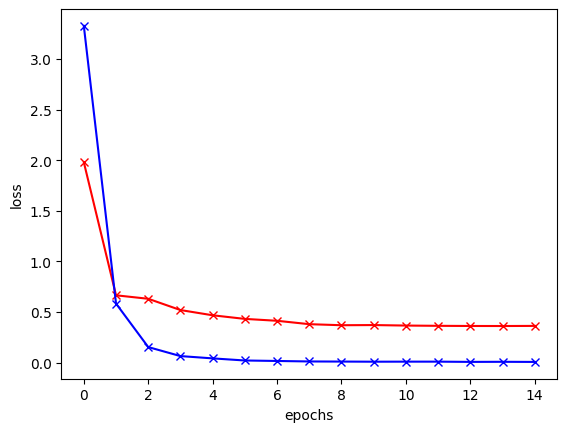

In [20]:
plt.plot(history_time, history['val_loss'].tolist(), c='red', label='val_loss', marker='x')
plt.plot(history_time, history['train_loss'].tolist(), c='blue', label='train_loss', marker='x')
plt.xlabel('epochs')
plt.ylabel('loss')

plt.show()

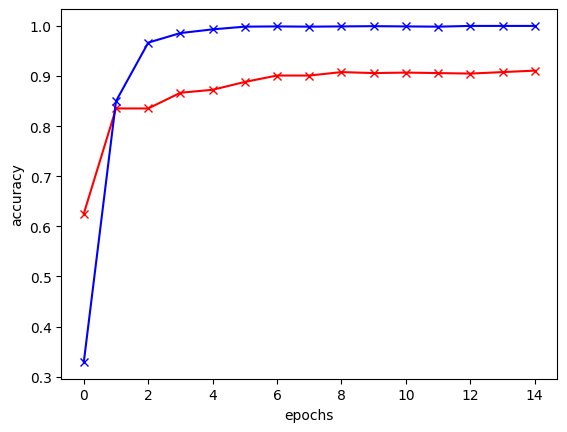

In [21]:
plt.plot(history_time, history['val_acc'], c='red', label='accuracy', marker='x')
plt.plot(history_time, history['train_acc'], c='blue', label='accuracy', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

#Visualize the result

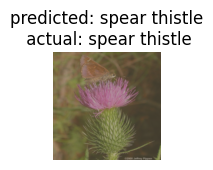

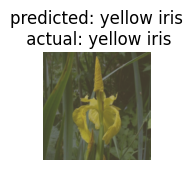

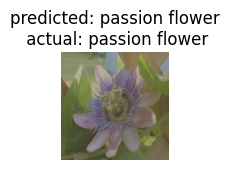

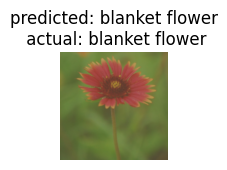

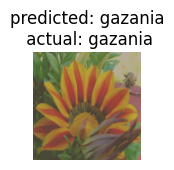

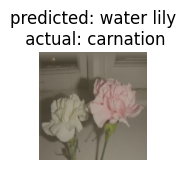

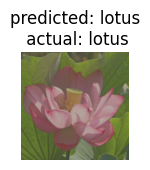

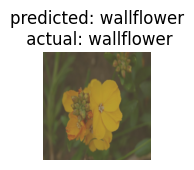

In [22]:
visualize_model(model, 8)

#Save the best model

In [25]:
from torch.utils.mobile_optimizer import optimize_for_mobile

scripted_model = torch.jit.script(model)
scripted_model.save("model.pt")
optimized_scripted_module = optimize_for_mobile(scripted_model)
optimized_scripted_module._save_for_lite_interpreter("model.ptl")

In [26]:
torch.save(model,"./content")